In [7]:
import os
import dotenv

import matplotlib.pyplot as plt
from pulser import Pulse, Register, Sequence
from pulser.devices import Chadoq2
from pasqal_cloud import SDK
from pasqal_cloud.device import EmulatorType

In [3]:
# Define a register for your sequence
register = Register.square(2, spacing=5, prefix="q")
# Create a sequence for that register
sequence = Sequence(register, Chadoq2)
# Add a channel to your sequence
sequence.declare_channel("rydberg", "rydberg_global")
# Declare a variable
omega_max = sequence.declare_variable("omega_max")
# Add a pulse to that channel with the amplitude omega_max
generic_pulse = Pulse.ConstantPulse(100, omega_max, 2, 0.0)
sequence.add(generic_pulse, "rydberg")

# When you are done building your sequence, serialize it into a string
serialized_sequence = sequence.to_abstract_repr()

In [8]:
dotenv.load_dotenv()
# Get credentials from environment variables
project_id = os.environ.get('PASQAL_PROJECT_ID') # Replace this value by your project_id on the PASQAL platform.
username = os.environ.get('PASQAL_USERNAME') # Replace this value by your username or email on the PASQAL platform.
password = os.environ.get('PASQAL_PASSWORD') # Replace this value by your password on the PASQAL platform.

# Check if all credentials are present
if not all([project_id, username, password]):
    raise ValueError("Missing PASQAL credentials. Please set environment variables.")

In [34]:
# Initialize the cloud client
sdk = SDK(username=username, password=password, project_id=project_id)

# When creating a job, select a number of runs and set the desired values for the variables
# defined in the sequence
job1 = {"runs": 20, "variables": {"omega_max": 6}}
job2 = {"runs": 50, "variables": {"omega_max": 10.5}}

# You can also choose to run your batch on an emulator using the optional argument 'emulator'
# For using a basic single-threaded QPU emulator that can go up to 10 qubits, you can specify the "EMU_FREE" emulator.
batch = sdk.create_batch(
    serialized_sequence, [job1, job2], emulator=EmulatorType.EMU_FREE
)

# Once the QPU has returned the results, you can access them with the following:
for job in batch.ordered_jobs:
    print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")


job-id: a53eedbb-c3f5-4f42-9fa1-df896755a595, status: PENDING, result: None
job-id: 15d39111-68f6-47fd-926d-0f3a34b62053, status: PENDING, result: None


In [36]:
result = sdk.get_batch(batch.id)
count_dict = result.ordered_jobs[0].result

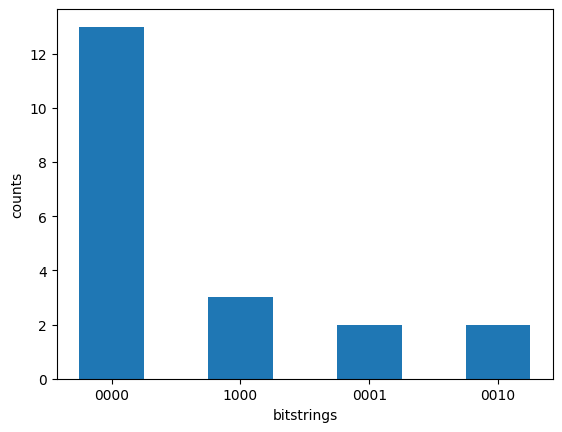

In [37]:
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
plt.figure()
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.bar(count_dict.keys(), count_dict.values(), width=0.5)
plt.xticks(rotation="horizontal")
plt.show()